In [119]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [120]:
def initial_data_preparation():
    

    data = pd.read_csv("../data/interim/spark_processed_data.csv", sep="|")

    
    
    print(f"{len(data)} Rows.")
   

    multi_choice_columns = pd.read_csv("../data/interim/spark_multi_choice_columns.csv", sep="|")["0"].tolist()
    
    data = data.drop(multi_choice_columns, axis=1)
    
    # Preserve country columns for target transformation
    data["Country_for_target_transformation"] = data["Country"]
    
    #Drop observations have less then $100 ConvertedComp and professional dev.
    data = data[(~(data["ConvertedComp"]<100) &  (data.MainBranch == "I am a developer by profession"))]

    #Drop observations have greater then $0.5M ConvertedComp
    data = data[data["ConvertedComp"]<=500000]
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", 
                                        "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    data = data[data["ConvertedComp"] >0]
    
    #Drop countries that has less than 150 observation
    countries = data["Country_for_target_transformation"].value_counts()
    countries_to_drop = countries[countries <= 200].index.tolist()
    data = data[~data["Country_for_target_transformation"].isin(countries_to_drop)].reset_index(drop=True)
    
    
    print(f"{len(data)} Rows.")
    
    
    # Fill NaNs with median
    nas = data.isna().sum()
    nas = nas[nas > 0]

    for na_col in nas.index:
        data[na_col].fillna(data[na_col].median(), inplace=True)

    #LABEL :"ConvertedComp"
    return data

In [121]:
def load_processed_data(force_processing=False):
    if force_processing:
        data = initial_data_preparation()
        data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    else:
        try:
            data = pd.read_csv("../data/processed/processed_data.csv", sep="|")
        except Exception as e:
            print(e)
            data = initial_data_preparation()
            data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    
    return data

data = load_processed_data(force_processing=True)

64461 Rows.
25974 Rows.


In [122]:
data.head()

,Age,Age1stCode,ConvertedComp,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_IBM DB2,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_Couchbase,DatabaseWorkedWith_Couchbase,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_Redis,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_Cassandra,DevType_Scientist,"DevType_Developer, back-end","DevType_Developer, desktop or enterprise applications","DevType_Developer, front-end","DevType_Developer, full-stack","DevType_Developer, game or graphics","DevType_Developer, mobile",DevType_Academic researcher,DevType_Database administrator,DevType_Designer,"DevType_Developer, QA or test","DevType_Engineer, data",DevType_Data or business analyst,DevType_Product manager,DevType_Data scientist or machine learning specialist,"DevType_Developer, embedded applications or devices",DevType_DevOps specialist,DevType_System administrator,DevType_Senior executive/VP,"DevType_Engineer, site reliability",DevType_Engineering manager,DevType_Educator,DevType_Marketing or sales professional,Ethnicity_White or of European descent,Ethnicity_South Asian,Ethnicity_East Asian,Ethnicity_Biracial,Ethnicity_Multiracial,Ethnicity_Black or of African descent,Ethnicity_Southeast Asian,Ethnicity_Middle Eastern,"Ethnicity_Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",Ethnicity_Hispanic or Latino/a/x,Gender_Man,"Gender_Non-binary, genderqueer, or gender non-conforming",Gender_Woman,JobFactors_Industry that I’d be working in,"JobFactors_Languages, frameworks, and other technologies I’d be working with",JobFactors_How widely used or impactful my work output would be,JobFactors_Office environment or company culture,JobFactors_Opportunities for professional development,JobFactors_Remote work options,JobFactors_Diversity of the company or organization,JobFactors_Specific department or team I’d be working on,JobFactors_Financial performance or funding status of the company or organization,JobFactors_Family friendliness,JobFactors_Flex time or a flexible schedule,LanguageDesireNextYear_C#,LanguageDesireNextYear_Bash/Shell/PowerShell,LanguageDesireNextYear_JavaScript,LanguageDesireNextYear_Python,LanguageDesireNextYear_R,LanguageDesireNextYear_SQL,LanguageDesireNextYear_C,LanguageDesireNextYear_C++,LanguageDesireNextYear_Dart,LanguageDesireNextYear_HTML/CSS,LanguageDesireNextYear_Java,LanguageDesireNextYear_Kotlin,LanguageDesireNextYear_Objective-C,LanguageDesireNextYear_Perl,LanguageDesireNextYear_Swift,LanguageDesireNextYear_TypeScript,LanguageDesireNextYear_PHP,LanguageDesireNextYear_Haskell,LanguageDesireNextYear_Go,LanguageDesireNextYear_Rust,LanguageDesireNextYear_Julia,LanguageDesireNextYear_VBA,LanguageDesireNextYear_Ruby,LanguageDesireNextYear_Scala,LanguageDesireNextYear_Assembly,LanguageWorkedWith_Assembly,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_C,LanguageWorkedWith_C#,LanguageWorkedWith_C++,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,LanguageWorkedWith_VBA,LanguageWorkedWith_R,LanguageWorkedWith_Java,LanguageWorkedWith_Kotlin,LanguageWorkedWith_Scala,LanguageWorkedWith_Swift,LanguageWorkedWith_Ruby,LanguageWorkedWith_Objective-C,LanguageWorkedWith_Dart,LanguageWorkedWith_Go,LanguageWorkedWith_Perl,LanguageWorkedWith_Rust,Language

## TODO

- Dev Type'a göre en çok kullanılan teknolojiler ve herkes bunlardan ne kadarını biliyor. **Erdem**
- Sunum Hazırlama **Bengi**
- Rapor **Berk**

In [123]:
def target_transformation(x_train, x_test, y_train, y_test):
    train_set = pd.concat([x_train, y_train], axis=1)
    test_set = pd.concat([x_test, y_test], axis=1)
    
    avg_prf_comp_by_country = train_set.groupby("Country_for_target_transformation").ConvertedComp.median()
    target_transformer = lambda row: (row['ConvertedComp'] / avg_prf_comp_by_country[row["Country_for_target_transformation"]]) *100
    
    y_train = train_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    y_test = test_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    
    y_train = np.log10(y_train)
    y_test = np.log10(y_test)
    
    return x_train, x_test, y_train, y_test
    

In [124]:
def calculate_high_and_low_leverage_tech(data):
            technologies = [feat for feat in data.columns if "WorkedWith" in feat]
            us_data = data[data["Country_for_target_transformation"] =="United States"]
            tech_leverages = {}
            for tech in technologies:
                tech_median = us_data.groupby(tech).ConvertedComp.median()
                if len(tech_median) != 2: continue
                tech_leverage = (tech_median.loc[1] / tech_median.loc[0]) -1
                tech_leverages[tech] = tech_leverage
            tech_leverages = pd.Series(tech_leverages).sort_values(ascending=False)

            high_leverage_technologies = tech_leverages[tech_leverages >= tech_leverages.quantile(0.80)].index.tolist()
            low_leverage_technologies = tech_leverages[tech_leverages <= tech_leverages.quantile(0.20)].index.tolist()
            return high_leverage_technologies, low_leverage_technologies

In [125]:
def prepare_data(data=data, 
                 exclude_columns=None, 
                 features_to_use=None, 
                 apply_x_col=None, 
                 columns_to_bin=None,
                 transform_target=False,
                 feat_agg_calculate_chosen_options_ratio=False,
                 feat_agg_worked_with_high_and_low_leverage=False,
                 feat_agg_worked_with_relevant_tech=False):

    
    if exclude_columns is not None and features_to_use is not None:
        raise Exception("exclude_columns and features_to_use cannot be used at the same time.")

    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    if features_to_use is not None:
        data = data[features_to_use + ["revenue"]]
        
    if feat_agg_calculate_chosen_options_ratio:
        def proportion_chosen_options(columns_contains):
            desire_next_year_feats = [feat for feat in data.columns if columns_contains in feat]
            return data[desire_next_year_feats].sum(axis=1) / len(desire_next_year_feats)
        
        data["feat_agg_proportion_chosen_DesireNextYear"] = proportion_chosen_options("DesireNextYear")
        data["feat_agg_proportion_chosen_LanguageDesireNextYear"] = proportion_chosen_options("LanguageDesireNextYear")
        data["feat_agg_proportion_chosen_PlatformDesireNextYear"] = proportion_chosen_options("PlatformDesireNextYear")
        data["feat_agg_proportion_chosen_WebframeDesireNextYear"] = proportion_chosen_options("WebframeDesireNextYear")
        data["feat_agg_proportion_chosen_DatabaseDesireNextYear"] = proportion_chosen_options("DatabaseDesireNextYear")

        data["feat_agg_proportion_chosen_WorkedWith"] = proportion_chosen_options("WorkedWith")
        data["feat_agg_proportion_chosen_LanguageWorkedWith"] = proportion_chosen_options("LanguageWorkedWith")
        data["feat_agg_proportion_chosen_PlatformWorkedWith"] = proportion_chosen_options("PlatformWorkedWith")
        data["feat_agg_proportion_chosen_WebframeWorkedWith"] = proportion_chosen_options("WebframeWorkedWith")
        data["feat_agg_proportion_chosen_DatabaseWorkedWith"] = proportion_chosen_options("DatabaseWorkedWith")
        
        

    x = data.drop('ConvertedComp', axis=1)
    
    y = data['ConvertedComp']

    if apply_x_col is not None:
        x = x.apply(apply_x_col)
    

    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size = 0.33, 
                                                        random_state = 3, 
                                                        stratify=x["Country_for_target_transformation"])

    
    if feat_agg_worked_with_relevant_tech:
        
        usage_ratios = pd.read_csv("../data/interim/tech_groups_by_dev_type.csv", sep="|")
        dev_types = [col for col in data.columns if "DevType_" in col]

        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)

                    
        for dev_type in dev_types:
            relevant_tech = usage_ratios[usage_ratios.dev_type==dev_type].tech.tolist()
            
            x_train[f"feat_agg_proportion_worked_with_{dev_type}_tech"] = proportion_chosen_given_Tech(relevant_tech)
            x_test[f"feat_agg_proportion_worked_with__{dev_type}__tech"] = proportion_chosen_given_Tech(relevant_tech)

    
    
    
    if feat_agg_worked_with_high_and_low_leverage:
        
        high_leverage_technologies, low_leverage_technologies = calculate_high_and_low_leverage_tech(pd.concat([x_train, y_train], 
                                                                                                               axis=1))
        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)
        
        x_train["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_train["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        
        x_test["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_test["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        technologies = [feat for feat in data.columns if (("WorkedWith" in feat) or ("DesireNextYear" in feat))]
        x_train = x_train.drop(technologies, axis=1)
        x_test = x_test.drop(technologies, axis=1)
    
    
    if transform_target:
        x_train, x_test, y_train, y_test = target_transformation(x_train, x_test, y_train, y_test)
    
    #Preserved from initial data preparation for target_transformation
    x_train.drop(["Country_for_target_transformation"], axis=1, inplace=True)
    x_test.drop(["Country_for_target_transformation"], axis=1, inplace=True)
        
    

    if columns_to_bin is not None:
        for column in columns_to_bin:
            if column not in x_train.columns: continue
            x_train.loc[:,column], bins_ = pd.qcut(x_train.loc[:,column], q=4,  retbins=True, duplicates="drop")
            x_test.loc[:,column] = pd.cut(x_test.loc[:,column], bins=bins_, )
            
            x_train = pd.get_dummies(x_train)
            x_test = pd.get_dummies(x_test)
    
    return x_train, x_test, y_train, y_test, data

In [126]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

    x_train_scaled.fillna(x_train_scaled.median(), inplace=True)
    x_test_scaled.fillna(x_test_scaled.median(), inplace=True)

    return x_train_scaled, x_test_scaled

In [127]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name="", model=None, num_feat=""):
    mape_train = np.abs((y_true_train - y_pred_train) / y_true_train).mean(axis=0)
    mape_test = np.abs((y_true_test - y_pred_test) / y_true_test).mean(axis=0)
    return pd.DataFrame.from_records([[#metrics.mean_squared_error(y_true_train, y_pred_train),
                                        mape_train,
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      #metrics.mean_squared_error(y_true_test, y_pred_test),
                                        mape_test,
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test),
                                       model,
                                       num_feat,
                                         y_true_test, 
                                        y_pred_test]],
                                     
                                     index=[model_name], 
                                     columns=[#'mean_squared_error_train', 
                                             "mape_train",
                                              'mean_absolute_error_train', 
                                              'max_error_train', 
                                              "r2_score_train",
                                              #'mean_squared_error_test', 
                                                 "mape_test",
                                              'mean_absolute_error_test', 
                                              'max_error_test', 
                                              "r2_score_test", 
                                              "model_object", 
                                              "num_feat",
                                             "y_true_test", 
                                             "y_pred_test"])


In [128]:
def run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=None):
        results = pd.DataFrame()
        for model in [#linear_model.LinearRegression(), 
                        linear_model.RidgeCV(),
                        linear_model.LassoCV(),
                        svm.LinearSVR(),
                        #svm.SVR(kernel="rbf",),
                        #svm.SVR(kernel="poly"),
                        tree.DecisionTreeRegressor(),
                        RandomForestRegressor()
                     ]:
                
                if feture_elimination_num_feat is not None :
                        try:
                                if feture_elimination_num_feat == "auto":
                                        feture_elimination_num_feat = np.linspace(5,len(x_train.columns),5, dtype=int)

                                for n_features_to_select in feture_elimination_num_feat:
                                        model_ = RFE(estimator=model, n_features_to_select=n_features_to_select)
                                        model_.fit(x_train, y_train)
                                        y_train_pred = model_.predict(x_train)
                                        y_test_pred = model_.predict(x_test)

                                        results = results.append(evaluate_regression(y_train, y_train_pred, y_test, y_test_pred,
                                                                model_name=type(model_).__name__, model=model_, num_feat=n_features_to_select))
                                return results
                        except Exception as e:
                            print(e)
                                
                        
               
                model.fit(x_train, y_train)
                
                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)

                results = results.append(evaluate_regression(y_train, y_train_pred, y_test, y_test_pred,
                                        model_name=type(model).__name__, model=model, num_feat=len(x_train.columns) ))
        return results


In [129]:
experiment_list = pd.DataFrame()

def run(exclude_columns=None, 
        features_to_use=None, 
        name="", 
        apply_x_col=None, 
        x_train_=None, 
        y_train_=None, 
        columns_to_bin=None,
        transform_target=False,
        feture_elimination_num_feat=None,
        feat_agg_calculate_chosen_options_ratio=False,
        feat_agg_worked_with_high_and_low_leverage=False,
       feat_agg_worked_with_relevant_tech=False):
    global experiment_list
    print(name)

    x_train, x_test, y_train, y_test, data = prepare_data(exclude_columns=exclude_columns, 
                                                        features_to_use=features_to_use, 
                                                        apply_x_col=apply_x_col,
                                                        columns_to_bin=columns_to_bin,
                                                          transform_target=transform_target,
                                                         feat_agg_calculate_chosen_options_ratio=feat_agg_calculate_chosen_options_ratio,
                                                         feat_agg_worked_with_high_and_low_leverage=feat_agg_worked_with_high_and_low_leverage,
                                                         feat_agg_worked_with_relevant_tech=feat_agg_worked_with_relevant_tech)

    if x_train_ is not None or y_train_ is not None:
        x_train, y_train = x_train_, y_train_

    x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)

    results = run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=feture_elimination_num_feat)

    best_model = results.sort_values("mean_absolute_error_test").reset_index().loc[[0], ["mean_absolute_error_train", 
                                                                                         "mape_train",
                                                                                         
                                                                                        "mean_absolute_error_test", 
                                                                                         "mape_test",
                                                                                        "index",
                                                                                        "num_feat",
                                                                                        "model_object"]].rename({0:name, "index":"model_name"})
    if experiment_list is not None:
        experiment_list = experiment_list.append(best_model)

    return results.sort_values("mean_absolute_error_test")

In [130]:
results = run(exclude_columns=None, name="Initial Run", transform_target=False)

Initial Run


In [131]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test
LassoCV,1.256704,24714.293870,474181.246869,0.464959,1.114471,25078.269254,451943.682064,0.456464,LassoCV(),572,24721 16219.0 15215 51888.0 4224 775...,"[22009.2545970462, 37768.40444570957, 111921.2..."
RandomForestRegressor,0.504123,9674.099480,195084.070000,0.921771,1.131739,25693.474153,439083.100000,0.458694,"(DecisionTreeRegressor(max_features='auto', ra...",572,24721 16219.0 15215 51888.0 4224 775...,"[24433.86, 49342.31, 80280.97, 69487.65, 57254..."
RidgeCV,1.285511,25002.198201,468784.012199,0.473644,1.156980,25771.843544,460363.850658,0.451490,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",572,24721 16219.0 15215 51888.0 4224 775...,"[27316.888535434235, 43314.8789779056, 116719...."
DecisionTreeRegressor,0.000000,0.000000,0.000000,1.000000,1.283303,36392.709519,460488.000000,-0.142861,DecisionTreeRegressor(),572,24721 16219.0 15215 51888.0 4224 775...,"[15096.0, 27624.0, 63337.0, 83194.0, 22476.0, ..."
LinearSVR,0.786745,56335.083770,491347.814453,-0.676966,0.759296,56389.947459,486439.780004,-0.685950,LinearSVR(),572,24721 16219.0 15215 51888.0 4224 775...,"[13639.990791102386, 18289.380969451755, 24976..."


In [132]:
y_true_test = results.loc["RandomForestRegressor", "y_true_test"]
y_pred_test = results.loc["RandomForestRegressor", "y_pred_test"]

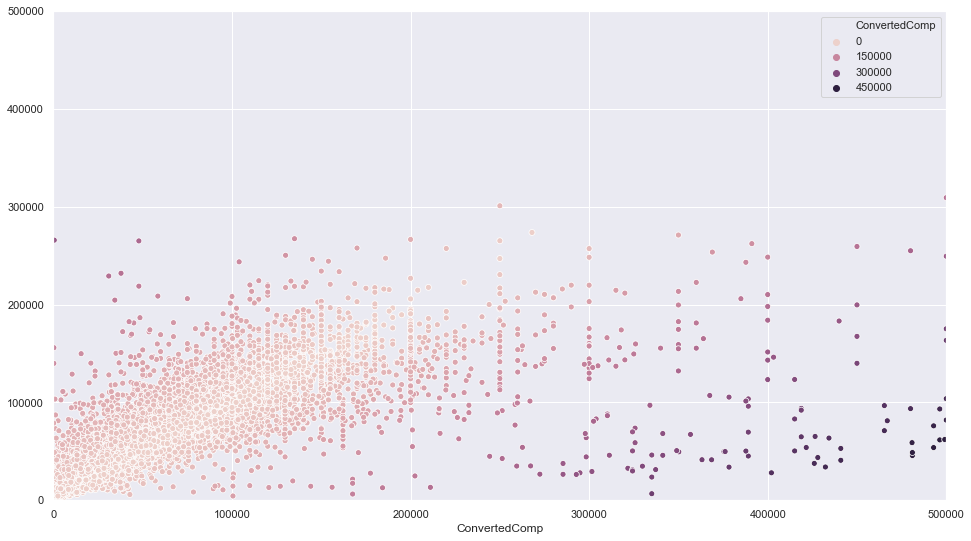

In [133]:
ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
plt.show()

In [134]:
results = run(exclude_columns=None, name="With Agg Features",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
             transform_target=True)

With Agg Features


In [135]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test
RandomForestRegressor,3.930142e-02,5.698783e-02,1.231960e+00,0.904426,0.093831,0.150639,2.907431,0.324936,"(DecisionTreeRegressor(max_features='auto', ra...",372,24721 1.931774 15215 2.045713 4224 2...,"[1.882731935409325, 1.9720308639459472, 2.0811..."
LassoCV,1.090687e-01,1.583008e-01,2.917248e+00,0.304050,0.098864,0.159381,3.029839,0.279908,LassoCV(),372,24721 1.931774 15215 2.045713 4224 2...,"[1.9245754763443204, 1.92114545114558, 2.16386..."
RidgeCV,1.092482e-01,1.588470e-01,2.913879e+00,0.306727,0.099352,0.160302,3.044306,0.278417,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",372,24721 1.931774 15215 2.045713 4224 2...,"[1.9316310449654113, 1.9415881439116212, 2.144..."
LinearSVR,1.235912e-01,1.866533e-01,2.960732e+00,0.140699,0.110646,0.185340,2.857414,0.127392,LinearSVR(),372,24721 1.931774 15215 2.045713 4224 2...,"[2.056665263141611, 1.9792297673635535, 2.1321..."
DecisionTreeRegressor,5.042332e-20,1.148375e-19,4.440892e-16,1.000000,0.134707,0.231617,3.303001,-0.520855,DecisionTreeRegressor(),372,24721 1.931774 15215 2.045713 4224 2...,"[1.9089195306526674, 1.9089195306526674, 2.116..."


In [136]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
             transform_target=True)

With Agg Features + relevant tech groups


In [137]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test
RandomForestRegressor,4.002790e-02,5.699801e-02,1.216622e+00,0.905236,0.093540,0.150431,2.891076,0.324102,"(DecisionTreeRegressor(max_features='auto', ra...",395,24721 1.931774 15215 2.045713 4224 2...,"[1.8598083693044902, 1.958845352730348, 2.0603..."
LassoCV,1.086423e-01,1.578615e-01,2.936619e+00,0.307228,0.098689,0.159051,3.028245,0.282471,LassoCV(),395,24721 1.931774 15215 2.045713 4224 2...,"[1.9369439442516092, 1.9215461768265665, 2.169..."
RidgeCV,1.087647e-01,1.583562e-01,2.923535e+00,0.310089,0.099204,0.160003,3.044998,0.280993,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",395,24721 1.931774 15215 2.045713 4224 2...,"[1.940302529940024, 1.9427748660782038, 2.1577..."
LinearSVR,1.220396e-01,1.873112e-01,3.096140e+00,0.138687,0.112439,0.187086,2.907411,0.113411,LinearSVR(),395,24721 1.931774 15215 2.045713 4224 2...,"[1.7856693904200365, 1.9469969341888842, 2.103..."
DecisionTreeRegressor,4.505781e-20,7.655831e-20,2.220446e-16,1.000000,0.134343,0.230211,3.303001,-0.491004,DecisionTreeRegressor(),395,24721 1.931774 15215 2.045713 4224 2...,"[1.8909442163996026, 1.9089195306526674, 1.975..."


In [138]:
experiment_list

,mean_absolute_error_train,mape_train,mean_absolute_error_test,mape_test,index,num_feat,model_object
Initial Run,24714.293870,1.256704,25078.269254,1.114471,LassoCV,572,LassoCV()
With Agg Features,0.056988,0.039301,0.150639,0.093831,RandomForestRegressor,372,"(DecisionTreeRegressor(max_features='auto', ra..."
With Agg Features + relevant tech groups,0.056998,0.040028,0.150431,0.093540,RandomForestRegressor,395,"(DecisionTreeRegressor(max_features='auto', ra..."


In [ ]:
results = run(name="Initial Run + Feat Selection", feture_elimination_num_feat="auto", transform_target=True)
results

Initial Run + Feat Selection


In [ ]:
results = run(exclude_columns=None, name="With Agg Features + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
             feture_elimination_num_feat="auto",
             transform_target=True)
results

In [ ]:
experiment_list